In [1]:
using DataFrames, Arrow, JLD2
using Statistics, NaNMath
using Plots, StatsPlots, ColorSchemes, Plots.Measures
using DifferentialEquations, DiffEqParamEstim
using Optim

G(z, zstar) = z < zstar ? z : zstar 
@register G(z, zstar)

"""
Interface limited model for biofilm growth,
assumes that nutrients are infinite
"""
function interface_limited(du, u, p, t)
    h = u[1] 
    α, β, hstar = p
    du[1] = α*G.(h, hstar) - β*h 
    return du
end

"""
Fits the experimental data to the interface 
limited interface model. Returns the best parameters
growth, decay and critical height
"""
function fit_model(prob, tdata, zdata)
    cost_function = build_loss_objective(prob, Tsit5(), L2Loss(tdata, zdata),
                    maxiters=100000, verbose=false)
    result_bfgs = Optim.optimize(cost_function, [0.3, 0.015, 15.5], Optim.BFGS())
    min = result_bfgs.minimizer
    return min 
end

fit_model

In [37]:
Df = jldopen("/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/profile_database.jld2", "r")["df"];
#param_frame = jldopen("/home/pablo/Biofilms/scripts/biofilm_surface_growth/figs/fig_scripts/fit_params.jld2", "r")["param_frame"];

EC_A = abs.(filter(row -> row.Replicate .== "A" && row.Strain .== "JT305L" && row.Time .<= 50, Df).avg_height)
EC_B = abs.(filter(row -> row.Replicate .== "B" && row.Strain .== "JT305L" && row.Time .<= 50, Df).avg_height)
EC_C = abs.(filter(row -> row.Replicate .== "C" && row.Strain .== "JT305L" && row.Time .<= 50, Df).avg_height)
EC_C[52] += 30
EC_C[53] -= 12
EC_C[78] += 40
tEC_A = filter(row -> row.Replicate .== "A" && row.Strain .== "JT305L" && row.Time .<= 50, Df).Time[1:end-1]
tEC_B = filter(row -> row.Replicate .== "B" && row.Strain .== "JT305L" && row.Time .<= 50, Df).Time[1:end-1]
tEC_C = filter(row -> row.Replicate .== "C" && row.Strain .== "JT305L" && row.Time .<= 50, Df).Time[1:end-1]

Ae_A = abs.(filter(row -> row.Replicate .== "A" && row.Strain .== "BGT127", Df).avg_height)
Ae_B = abs.(filter(row -> row.Replicate .== "B" && row.Strain .== "BGT127", Df).avg_height)
Ae_C = abs.(filter(row -> row.Replicate .== "C" && row.Strain .== "BGT127", Df).avg_height)
tAe_A = filter(row -> row.Replicate .== "A" && row.Strain .== "BGT127", Df).Time
tAe_B = filter(row -> row.Replicate .== "B" && row.Strain .== "BGT127", Df).Time
tAe_C = filter(row -> row.Replicate .== "C" && row.Strain .== "BGT127", Df).Time

tEC, EC = [tEC_A, tEC_B, tEC_C], [EC_A, EC_B, EC_C]
tAe, Ae = [tAe_A, tAe_B, tAe_C], [Ae_A, Ae_B, Ae_C]

(Vector{Float32}[[0.41666666, 0.7405556, 1.0638889, 1.3877778, 1.7116667, 2.036111, 2.36, 2.683889, 3.0083334, 3.3322222  …  42.02667, 42.705555, 43.384445, 44.06333, 44.741665, 45.421665, 46.1, 46.779446, 47.458332, 48.137222], [0.5238889, 0.8472222, 1.1711111, 1.495, 1.8188889, 2.1427777, 2.4672222, 2.791111, 3.1155555, 3.4394445  …  42.16722, 42.84611, 43.52611, 44.205, 44.88389, 45.56222, 46.240555, 46.92, 47.59889, 48.27722], [0.6333333, 0.95666665, 1.2805556, 1.6044445, 1.9288889, 2.2527778, 2.5766666, 2.9005556, 3.225, 3.5505555  …  42.314445, 42.993332, 43.671665, 44.350555, 45.029446, 45.70778, 46.386665, 47.066113, 47.745556, 48.424446]], [[0.3221055452991689, 0.26389577648196255, 0.4476834492578231, 0.7498301632717373, 0.3663164525584064, 0.2883838297836276, 0.08868572300271656, 0.028757883855869675, 0.8513950816460689, 1.2407962700420936  …  198.40313860430282, 198.6650366642065, 199.24644690559148, 199.87015141113443, 200.73723782611847, 200.96007891593544, 205.20259290429

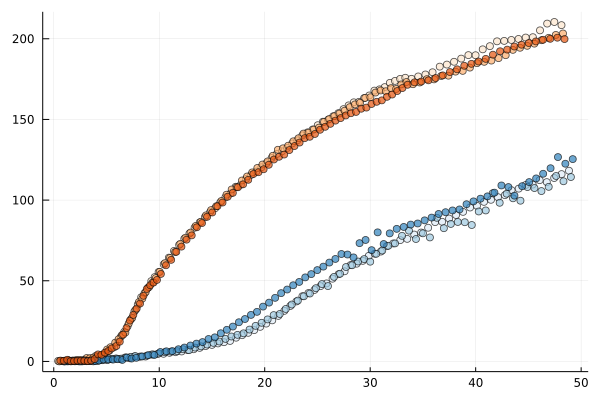

In [38]:
pbase = plot()
for i=1:3
    scatter!(tEC[i], EC[i][1:end-1], c=ColorSchemes.Blues_3[i], alpha=0.7, label=false)
    scatter!(tAe[i], Ae[i], c=ColorSchemes.Oranges_3[i], alpha=0.7, label=false)
end
plot(pbase)

In [9]:
unique(Df.Strain)

6-element Vector{String}:
 "SN503"
 "JT1080"
 "BH1543"
 "BGT127"
 "JT305"
 "JT305L"

In [39]:
function add_to_database(df, dict, n, long, cont)
    times = npzread(string(dict["folder"], "times.npy"))
    replicate = ["A", "B", "C", "D", "E", "F", "G", "H", "I"] # Improve this
    repl_long = ["A", "B", "C", "D", "D", "E", "E", "F", "F", "G", "G", "H", "H", "I", "I", "J", "K", "L"]
    # Main (timelapse) points
    for i=1:n
        profile = npzread(string(dict["folder"], "profiles_",    
                          replicate[i],".npy"))
        if long 
            for j=1:(size(times)[2]-1)
                rowdata = (dict["strain"], dict["date"], replicate[i], times[i,j], j,
                        dict["zoom"], dict["by"], profile[j,:])
                push!(df, rowdata)
            end 
        else 
            for j=1:(size(times)[2])
                rowdata = (dict["strain"], dict["date"], replicate[i], times[i,j], j,
                        dict["zoom"], dict["by"], profile[j,:])
                push!(df, rowdata)
            end 
        end
    end

    if cont
        # Secondary (control) points 
        control_times = npzread(string(dict["folder"], "times_control.npy"))
        control_profiles = npzread(string(dict["folder"], "profiles_control.npy"))

        if long
            for i=1:size(control_times)[1]
                if i in [1,2,3,4,6,8]
                    zoom = 50
                else 
                    zoom = 10
                end
                rowdata = (dict["strain"], dict["date"], repl_long[i], control_times[i], i, zoom, dict["by"], control_profiles[i,:])
                push!(df, rowdata)
            end
        else 
            for i=1:size(control_times)[1]
                zoom = i < 4 ? 50 : 10           # ABCDEF are 50x, GHI are 10x due to size
                rowdata = (dict["strain"], dict["date"], replicate[i+3], control_times[i], i, zoom, dict["by"], control_profiles[i,:])
                push!(df, rowdata)
            end
        end
    end

    println(string("Added " , dict["strain"]))
end

df = DataFrame(Strain = String[], Date = String[], Replicate = String[], 
               Time = Float32[], Order=Int32[], Zoom = Float32[], 
               By = String[], Profile = Array[]);
println("Columns created")
# Petite yeast
pyeast = Dict("folder" => "/home/pablo/Documents/GitHub/biofilm_surface_growth/data/timelapses/2021-09-03_pyeast/",
              "strain" => "pyeast", "date" => "2021-09-03", 
              "zoom" => 50, "by" => "pbravo")
add_to_database(df, pyeast, 3, false, false)

df.mid_height = [df.Profile[i][Int(floor(length(df.Profile[i])/2))] for i=1:size(df)[1]]
df.max_height = [NaNMath.maximum(df.Profile[i]) for i=1:size(df)[1]]
l = [findall(x->!isnan(x), y)[1] for y in df.Profile]
r = [findall(x->!isnan(x), y)[end] for y in df.Profile]
df.width = (r-l)* 0.17362 * 1e-3 * 50 ./ df.Zoom

h = 2e3 ./ (0.17362 * 50 ./ df.Zoom)
df.hL = Int.(floor.(length.(df.Profile)/2 .- h./2))
df.hR = Int.(floor.(length.(df.Profile)/2 .+ h./2))
df.avg_height = [NaNMath.mean(df.Profile[i][df.hL[i]:df.hR[i]]) for i=1:size(df)[1]]
df.std_height = [NaNMath.std(df.Profile[i][df.hL[i]:df.hR[i]]) for i=1:size(df)[1]]

Columns created
Added pyeast


306-element Vector{Float64}:
  0.2696216200239968
  0.38336176339232747
  0.21868587238138718
  0.27196440802002825
  0.33712838193224526
  0.2598473812621169
  0.2551736814581176
  0.33424853869949267
  0.3038511584718072
  0.413949187412951
  0.49182338011542215
  0.5640260939696454
  0.5660655484239946
  ⋮
 12.302542728778818
 14.021027626828655
 13.514897623064696
 12.390808877486942
 13.496143253522977
 13.215637456271677
 13.95033717781982
 13.440077878037426
 13.143516054931695
 13.146149280984972
 13.468491809399382
 14.115106293635515

In [40]:
PY_A = abs.(filter(row -> row.Replicate .== "A" && row.Strain .== "pyeast", df).avg_height)
PY_B = abs.(filter(row -> row.Replicate .== "B" && row.Strain .== "pyeast", df).avg_height)
PY_C = abs.(filter(row -> row.Replicate .== "C" && row.Strain .== "pyeast", df).avg_height)
tPY_A = filter(row -> row.Replicate .== "A" && row.Strain .== "pyeast", df).Time[1:end-1]
tPY_B = filter(row -> row.Replicate .== "B" && row.Strain .== "pyeast", df).Time[1:end-1]
tPY_C = filter(row -> row.Replicate .== "C" && row.Strain .== "pyeast", df).Time[1:end-1]
tPY, PY = [tPY_A, tPY_B, tPY_C], [PY_A, PY_B, PY_C]



(Vector{Float32}[[0.35694444, 0.69027776, 1.0230556, 1.3580556, 1.6908333, 2.0241666, 2.3580556, 2.6913888, 3.0258334, 3.3591666  …  41.538612, 42.079723, 42.620834, 43.16139, 43.706944, 44.25083, 44.79361, 45.338055, 45.8825, 46.4275], [0.43916667, 0.77194446, 1.1063889, 1.4397222, 1.7730556, 2.1069446, 2.4402778, 2.773611, 3.1080556, 3.4408333  …  41.689167, 42.22972, 42.770832, 43.31361, 43.859165, 44.40139, 44.945835, 45.490276, 46.03472, 46.579723], [0.51916665, 0.8525, 1.1869445, 1.5202777, 1.8530556, 2.1875, 2.5208333, 2.853611, 3.1880555, 3.521389  …  41.836945, 42.376945, 42.91861, 43.461388, 44.00639, 44.549168, 45.093056, 45.638054, 46.183056, 46.726944]], [[1.2359436735186387, 2.192113439760535, 0.8582917269542741, 0.7110055945727244, 1.0743964790624536, 1.7008837230791178, 0.9745803223279347, 1.985205661174958, 1.260812671935999, 3.7722892759420814  …  218.6994340591823, 210.42742078166006, 224.29718811653854, 235.03640522317033, 216.41009172603864, 218.52738778892615, 213

In [56]:
pbase = plot()
for i=1:3
    scatter!(tEC[i], EC[i][1:end-1], c=ColorSchemes.Blues_3[i], alpha=0.7, label=false)
    scatter!(tAe[i], Ae[i], c=ColorSchemes.Oranges_3[i], alpha=0.7, label=false)
    scatter!(tPY[i], PY[i], c=ColorSchemes.Greens_3[i], alpha=0.7, label=false)
end
plot(pbase, xlabel="Time (hr)", ylabel="Height (μm)", grid=false)
savefig("/home/pablo/Documents/GitHub/biofilm_surface_growth/figs/growth_48h.svg") # save the most recent fig as fn



In [58]:
pbase = @df filter(row -> row.mid_height .>= 230, Df[Df.Strain .== "JT305L", :]) scatter!(:Time, :mid_height, marker=:circle, alpha=0.7, 
            xlabel="Time (hr)", ylabel="Height (μm)", color=ColorSchemes.Blues_3[3], label=false)
pbase = @df filter(row -> any(row.Replicate .== ["G", "H", "I"]), Df[Df.Strain .== "JT305", :]) scatter!(:Time, :avg_height, marker=:circle, alpha=0.7, 
            xlabel="Time (hr)", ylabel="Height (μm)", color=ColorSchemes.Blues_3[3],label=false)
pbase = @df filter(row -> any(row.Replicate .== ["G", "H", "I"]), Df[Df.Strain .== "BGT127", :]) scatter!(:Time, :avg_height, marker=:circle, alpha=0.7, 
            xlabel="Time (hr)", ylabel="Height (μm)", color=ColorSchemes.Oranges_3[3],label=false)

pbase = scatter!(PY_CT, PY_control, marker=:circle, alpha=0.7, color=ColorSchemes.Greens_3[3], label=false)
plot(pbase, xlim=(0, 350))
savefig("/home/pablo/Documents/GitHub/biofilm_surface_growth/figs/growth_2w.svg") # save the most recent fig as fn


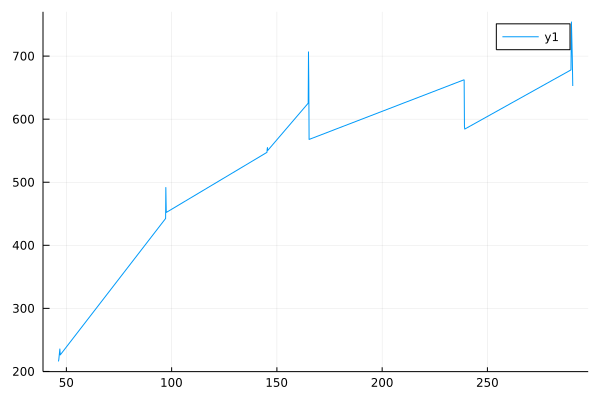

In [50]:
PY_control = npzread("/run/media/pablo/T7/Documents/Research/Biofilms/Data/Interferometry/radial_timelapses/2021-10-28_petiteyeastlong/Clean/z_avg.npy")
PY_CT = npzread("/run/media/pablo/T7/Documents/Research/Biofilms/Data/Interferometry/radial_timelapses/2021-10-28_petiteyeastlong/Clean/times.npy")
plot(PY_CT, PY_control)

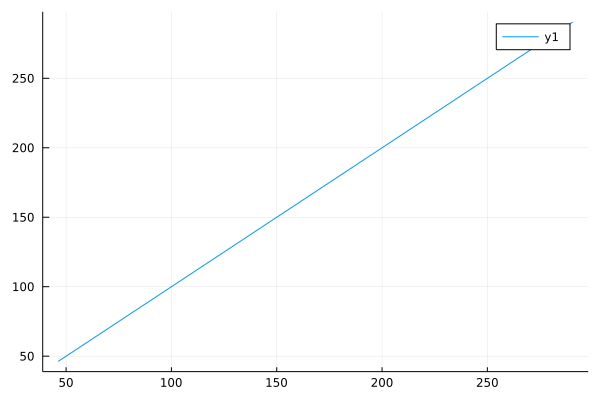

In [49]:
PY_control = npzread("/run/media/pablo/T7/Documents/Research/Biofilms/Data/Interferometry/radial_timelapses/2021-10-28_petiteyeastlong/Clean/z_avg.npy")


24×1 Matrix{Float64}:
  46.22694444444444
  46.389722222222225
  46.90027777777778
  47.08972222222222
  97.13861111111112
  97.24138888888889
  97.34472222222222
  97.44805555555556
 145.27416666666667
 145.39138888888888
 145.51305555555555
 145.6363888888889
 164.8675
 165.00805555555556
 165.1563888888889
 165.29305555555555
 238.80083333333334
 238.94694444444445
 239.08694444444444
 239.23416666666665
 289.6925
 289.9075
 290.32138888888886
 290.5397222222222